Loading route data...
✅ Loaded 67027 routes

First few rows:
  src_airport dst_airport
0         AER         KZN
1         ASF         KZN
2         ASF         MRV
3         CEK         KZN
4         CEK         OVB

NETWORK RECIPROCITY ANALYSIS

📊 Directed Graph Statistics:
   • Nodes (Airports): 3290
   • Directed Edges (Routes): 37123

🔄 Reciprocity Analysis:
   • Reciprocity Score: 0.9773 (97.73%)
   • Total Routes: 37,123
   • Reciprocated Routes: 36,280 (97.73%)
   • One-Way Routes: 843 (2.27%)

📝 Interpretation:
   ✈️ The network is HIGHLY RECIPROCAL (97.73%)
   → Most routes have return flights (typical for commercial aviation)


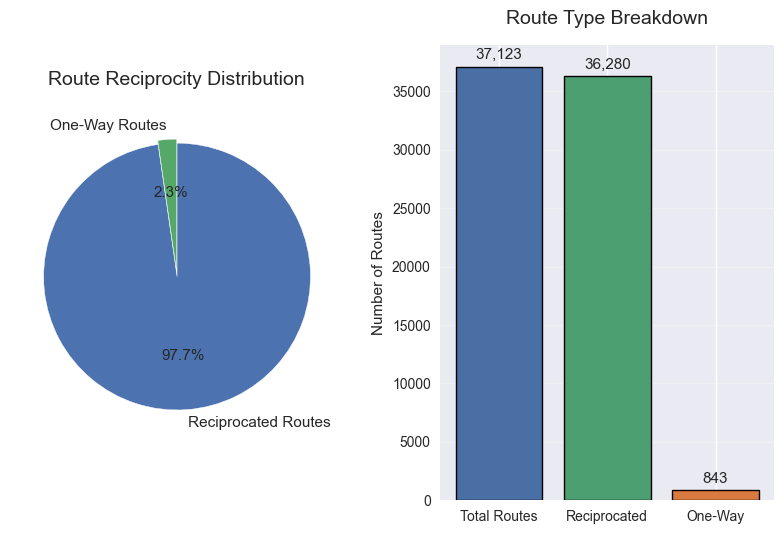

In [161]:
# Cell 1: Import Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Cell 2: Load Data
print("Loading route data...")
df = pd.read_csv("routes_cleaned.csv")
print(f"✅ Loaded {len(df)} routes")
print(f"\nFirst few rows:")
print(df.head())

# Cell 3: Network Reciprocity Analysis
print("\n" + "="*60)
print("NETWORK RECIPROCITY ANALYSIS")
print("="*60)

# Create a DIRECTED graph (DiGraph) to distinguish A→B from B→A
G_directed = nx.from_pandas_edgelist(
    df, 
    source='src_airport', 
    target='dst_airport', 
    create_using=nx.DiGraph()
)

print(f"\n📊 Directed Graph Statistics:")
print(f"   • Nodes (Airports): {G_directed.number_of_nodes()}")
print(f"   • Directed Edges (Routes): {G_directed.number_of_edges()}")

# Calculate Reciprocity
# Returns a value between 0.0 (no return flights) and 1.0 (perfectly symmetric)
reciprocity_score = nx.reciprocity(G_directed)

# Count actual numbers for the report
total_edges = G_directed.number_of_edges()
reciprocated_edges = int(total_edges * reciprocity_score)
one_way_edges = total_edges - reciprocated_edges

print(f"\n🔄 Reciprocity Analysis:")
print(f"   • Reciprocity Score: {reciprocity_score:.4f} ({reciprocity_score*100:.2f}%)")
print(f"   • Total Routes: {total_edges:,}")
print(f"   • Reciprocated Routes: {reciprocated_edges:,} ({reciprocity_score*100:.2f}%)")
print(f"   • One-Way Routes: {one_way_edges:,} ({(1-reciprocity_score)*100:.2f}%)")

print(f"\n📝 Interpretation:")
if reciprocity_score > 0.8:
    print(f"   ✈️ The network is HIGHLY RECIPROCAL ({reciprocity_score*100:.2f}%)")
    print(f"   → Most routes have return flights (typical for commercial aviation)")
elif reciprocity_score > 0.5:
    print(f"   ✈️ The network is MODERATELY RECIPROCAL ({reciprocity_score*100:.2f}%)")
    print(f"   → Mix of two-way and one-way routes")
else:
    print(f"   ✈️ The network is WEAKLY RECIPROCAL ({reciprocity_score*100:.2f}%)")
    print(f"   → Many one-way routes (unusual for flight networks)")

# Cell 4: Visualize Reciprocity (Improved Aesthetics)

# Use a clean visual style
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8')

fig, (ax1, ax2) = plt.subplots(1, 2)

# --- Pie Chart: Reciprocated vs One-Way ---
labels = ['Reciprocated Routes', 'One-Way Routes']
sizes = [reciprocated_edges, one_way_edges]

# Soft, professional color palette
colors = ['#4C9F70', '#D97A40']
explode = (0.03, 0)

ax1.pie(
    sizes,
    labels=labels,
    explode=explode,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    textprops={'fontsize': 11}
)
ax1.set_title('Route Reciprocity Distribution', fontsize=14, pad=15)


# --- Bar Chart: Route Breakdown ---
categories = ['Total Routes', 'Reciprocated', 'One-Way']
values = [total_edges, reciprocated_edges, one_way_edges]

bar_colors = ['#4A6FA5', '#4C9F70', '#D97A40']

bars = ax2.bar(categories, values, color=bar_colors, edgecolor='black', linewidth=1)

ax2.set_title('Route Type Breakdown', fontsize=14, pad=15)
ax2.set_ylabel('Number of Routes')

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        height + max(values)*0.01,
        f'{int(height):,}',
        ha='center', va='bottom', fontsize=11
    )

ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('network_reciprocity.png', dpi=300, bbox_inches='tight')
plt.show()



INITIAL MATRIX STATE

📐 Adjacency Matrix Properties:
   • Matrix Dimensions: 3290 × 3290
   • Matrix Type: Sparse CSR (Compressed Sparse Row)
   • Total Possible Connections: 10,824,100
   • Actual Connections (Non-zero): 37,123
   • Sparsity: 99.66%

🔍 Sample Matrix View (First 10 airports):

Adjacency Matrix (1 = route exists, 0 = no route):
     AER  KZN  ASF  MRV  CEK  OVB  DME  NBC  TGK  UUA
AER    0    1    0    0    0    0    1    0    0    0
KZN    1    0    1    0    1    0    1    0    0    0
ASF    0    1    0    1    0    0    1    0    0    0
MRV    0    0    1    0    0    0    1    0    0    0
CEK    0    1    0    0    0    1    1    0    0    0
OVB    0    0    0    0    1    0    1    0    0    0
DME    1    1    1    1    1    1    0    1    1    1
NBC    0    0    0    0    0    0    1    0    0    0
TGK    0    0    0    0    0    0    1    0    0    0
UUA    0    0    0    0    0    0    1    0    0    0


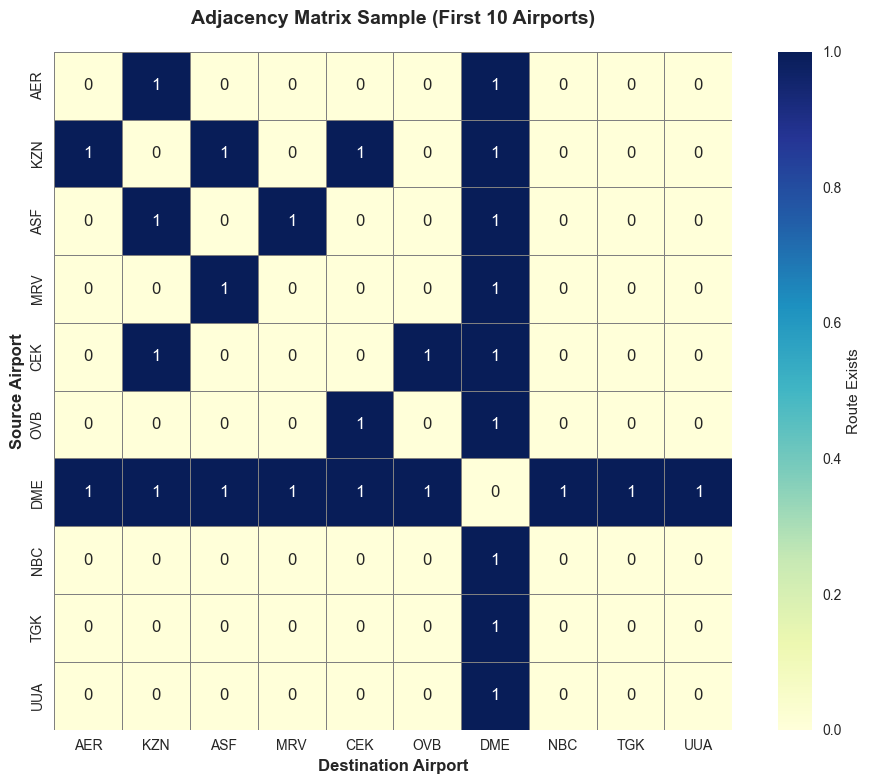


💾 Matrix visualization saved as 'adjacency_matrix_sample.png'

MATRIX SYMMETRY ANALYSIS

🔄 Checking Matrix Symmetry...

📊 Symmetry Statistics:
   • Symmetric Edges (A→B and B→A both exist): 36,281
   • Asymmetric Edges (only one direction): 842
   • Symmetry Ratio: 97.73%

🔍 Sample Matrix Symmetry Check:
   • Is the sample matrix symmetric? True

MATRIX PROPERTIES SUMMARY

📊 Network Adjacency Matrix Analysis

Matrix Type: Directed Adjacency Matrix (Binary)
Dimensions: 3290 × 3290

Sparsity Metrics:
• Total Possible Edges: 10,824,100
• Actual Edges (Non-zero): 37,123
• Sparsity: 99.66%
• Density: 0.3430%

Symmetry Analysis:
• Symmetric Edges: 36,281 (97.73%)
• Asymmetric Edges: 842 (2.27%)

Interpretation:
The adjacency matrix is highly sparse, 
meaning most airport pairs are not directly connected. This is typical for 
flight networks where direct routes are limited by distance, demand, and 
operational constraints.

The matrix is highly symmetric, 
indicating that 97.73% of routes ha

In [162]:
# Cell 5: Initial Matrix State Analysis
print("\n" + "="*60)
print("INITIAL MATRIX STATE")
print("="*60)

# Get the adjacency matrix (sparse representation is more efficient)
adjacency_matrix = nx.adjacency_matrix(G_directed)

print(f"\n📐 Adjacency Matrix Properties:")
print(f"   • Matrix Dimensions: {adjacency_matrix.shape[0]} × {adjacency_matrix.shape[1]}")
print(f"   • Matrix Type: Sparse CSR (Compressed Sparse Row)")
print(f"   • Total Possible Connections: {adjacency_matrix.shape[0] ** 2:,}")
print(f"   • Actual Connections (Non-zero): {adjacency_matrix.nnz:,}")
print(f"   • Sparsity: {(1 - adjacency_matrix.nnz / (adjacency_matrix.shape[0] ** 2)) * 100:.2f}%")

# Convert to dense for a small sample visualization
print(f"\n🔍 Sample Matrix View (First 10 airports):")

# Get first 10 nodes
sample_nodes = list(G_directed.nodes())[:10]
sample_subgraph = G_directed.subgraph(sample_nodes)
sample_matrix = nx.to_numpy_array(sample_subgraph, nodelist=sample_nodes, dtype=int)

# Create a DataFrame for better visualization
sample_df = pd.DataFrame(
    sample_matrix,
    index=sample_nodes,
    columns=sample_nodes
)

print("\nAdjacency Matrix (1 = route exists, 0 = no route):")
print(sample_df)

# Visualize the sample matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    sample_df,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar_kws={'label': 'Route Exists'},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    ax=ax
)

ax.set_title('Adjacency Matrix Sample (First 10 Airports)', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('Destination Airport', fontsize=12, weight='bold')
ax.set_ylabel('Source Airport', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('adjacency_matrix_sample.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Matrix visualization saved as 'adjacency_matrix_sample.png'")

# Cell 6: Matrix Symmetry Analysis
print("\n" + "="*60)
print("MATRIX SYMMETRY ANALYSIS")
print("="*60)

# Check symmetry (transpose comparison)
# For the full network, we'll sample to avoid memory issues
print(f"\n🔄 Checking Matrix Symmetry...")

# Count symmetric entries
symmetric_count = 0
asymmetric_count = 0

for u, v in G_directed.edges():
    if G_directed.has_edge(v, u):
        symmetric_count += 1
    else:
        asymmetric_count += 1

print(f"\n📊 Symmetry Statistics:")
print(f"   • Symmetric Edges (A→B and B→A both exist): {symmetric_count:,}")
print(f"   • Asymmetric Edges (only one direction): {asymmetric_count:,}")
print(f"   • Symmetry Ratio: {(symmetric_count / (symmetric_count + asymmetric_count)) * 100:.2f}%")

# Visualize symmetry for sample
symmetric_matrix = sample_df.values
is_symmetric = (symmetric_matrix == symmetric_matrix.T).all()

print(f"\n🔍 Sample Matrix Symmetry Check:")
print(f"   • Is the sample matrix symmetric? {is_symmetric}")

if not is_symmetric:
    # Show differences
    difference = symmetric_matrix - symmetric_matrix.T
    diff_df = pd.DataFrame(
        difference,
        index=sample_nodes,
        columns=sample_nodes
    )
    
    print(f"\n   Asymmetric pairs in sample:")
    asymmetric_pairs = []
    for i, src in enumerate(sample_nodes):
        for j, dst in enumerate(sample_nodes):
            if difference[i, j] != 0:
                asymmetric_pairs.append(f"      {src} → {dst}: {int(symmetric_matrix[i, j])} (reverse: {int(symmetric_matrix[j, i])})")
    
    for pair in asymmetric_pairs[:10]:  # Show first 10
        print(pair)

# Cell 7: Matrix Properties Summary
print("\n" + "="*60)
print("MATRIX PROPERTIES SUMMARY")
print("="*60)

summary_matrix = f"""
📊 Network Adjacency Matrix Analysis

Matrix Type: Directed Adjacency Matrix (Binary)
Dimensions: {adjacency_matrix.shape[0]} × {adjacency_matrix.shape[1]}

Sparsity Metrics:
• Total Possible Edges: {adjacency_matrix.shape[0] ** 2:,}
• Actual Edges (Non-zero): {adjacency_matrix.nnz:,}
• Sparsity: {(1 - adjacency_matrix.nnz / (adjacency_matrix.shape[0] ** 2)) * 100:.2f}%
• Density: {(adjacency_matrix.nnz / (adjacency_matrix.shape[0] ** 2)) * 100:.4f}%

Symmetry Analysis:
• Symmetric Edges: {symmetric_count:,} ({(symmetric_count / (symmetric_count + asymmetric_count)) * 100:.2f}%)
• Asymmetric Edges: {asymmetric_count:,} ({(asymmetric_count / (symmetric_count + asymmetric_count)) * 100:.2f}%)

Interpretation:
The adjacency matrix is {'highly sparse' if (1 - adjacency_matrix.nnz / (adjacency_matrix.shape[0] ** 2)) > 0.95 else 'moderately sparse'}, 
meaning most airport pairs are not directly connected. This is typical for 
flight networks where direct routes are limited by distance, demand, and 
operational constraints.

The matrix is {'highly symmetric' if (symmetric_count / (symmetric_count + asymmetric_count)) > 0.8 else 'moderately symmetric' if (symmetric_count / (symmetric_count + asymmetric_count)) > 0.5 else 'asymmetric'}, 
indicating that {(symmetric_count / (symmetric_count + asymmetric_count)) * 100:.2f}% of routes have return 
flights in both directions.
"""

print(summary_matrix)

# Save to file
with open('matrix_analysis_summary.txt', 'w') as f:
    f.write(summary_matrix)

print("\n💾 Matrix summary saved to 'matrix_analysis_summary.txt'")